In [21]:
#!/usr/bin/env python

from time import time

import sys
sys.path.insert(0, '../../../Utilities/')

from plotting import newfig, savefig
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import operator
import itertools

from sklearn import metrics
from sklearn.metrics import *
from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score

from sklearn import kernel_ridge
from sklearn.kernel_ridge import KernelRidge

#import xgboost
from sklearn.neural_network import MLPRegressor

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

n_jobs = 1
trial  = 1

# Import database
dataset=np.loadtxt("../../data/dataset_lite.csv", delimiter=",")
x=dataset[:,0:2]
y=dataset[:,2] # 0: X, 1: T, 2: shear, 3: bulk, 4: conductivity

# Plot dataset
#plt.scatter(x[:,1], dataset[:,2], s=0.5)
#plt.title('Shear viscosity')
#plt.xlabel('T [K]')
#plt.ylabel(r'$\eta$')
#plt.show()

y=np.reshape(y, (-1,1))
sc_x = StandardScaler()
sc_y = StandardScaler()
X = sc_x.fit_transform(x)
Y = sc_y.fit_transform(y)

# The data is then split into training and test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25, random_state=42)

print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (3300, 2)
Training Labels Shape: (3300, 1)
Testing Features Shape: (1100, 2)
Testing Labels Shape: (1100, 1)


In [ ]:
# MPL
hyper_params = [
    {
        'activation' : ('tanh', 'relu',),
        'solver' : ('lbfgs','adam','sgd',),
        'learning_rate' : ('constant', 'invscaling', 'adaptive',),
        'nesterovs_momentum': (True, False,),
    },
]

#params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0, 'learning_rate_init': 0.2},
#          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9, 'nesterovs_momentum': False, 'learning_rate_init': 0.2},
#          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9, 'nesterovs_momentum': True, 'learning_rate_init': 0.2},
#          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0, 'learning_rate_init': 0.2},
#          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9, 'nesterovs_momentum': True, 'learning_rate_init': 0.2},
#          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9, 'nesterovs_momentum': False, 'learning_rate_init': 0.2},
#          {'solver': 'adam', 'learning_rate_init': 0.01}]

est=MLPRegressor()

grid_clf = GridSearchCV(est, cv=5, param_grid=hyper_params, verbose=2, n_jobs=n_jobs, scoring='r2')

#t0 = time.time()
#svr.fit(x_train, y_train)
#svr_fit = time.time() - t0
#print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

t0 = time.time()
grid_clf.fit(x_train, y_train.ravel())
runtime = time.time() - t0
print("MLP complexity and bandwidth selected and model fitted in %.3f s" % runtime)

train_score_mse  = mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(grid_clf.predict(x_train)))
train_score_mae  = mean_absolute_error(sc_y.inverse_transform(y_train),sc_y.inverse_transform(grid_clf.predict(x_train)))
train_score_evs  = explained_variance_score(sc_y.inverse_transform(y_train), sc_y.inverse_transform(grid_clf.predict(x_train)))
train_score_me   = max_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(grid_clf.predict(x_train)))

test_score_mse  = mean_squared_error(sc_y.inverse_transform(y_test),  sc_y.inverse_transform(grid_clf.predict(x_test)))
test_score_mae  = mean_absolute_error(sc_y.inverse_transform(y_test), sc_y.inverse_transform(grid_clf.predict(x_test)))
test_score_evs  = explained_variance_score(sc_y.inverse_transform(y_test),  sc_y.inverse_transform(grid_clf.predict(x_test)))
test_score_me   = max_error(sc_y.inverse_transform(y_test),  sc_y.inverse_transform(grid_clf.predict(x_test)))

sorted_grid_params = sorted(grid_clf.best_params_.items(), key=operator.itemgetter(0))

out_text = '\t'.join(['mpl',
                      str(trial),
                      str(sorted_grid_params).replace('\n',','),
                      str(train_score_mse),
                      str(train_score_mae),
                      str(train_score_evs),
                      str(train_score_me),
                      str(test_score_mse),
                      str(test_score_mae),
                      str(test_score_evs),
                      str(test_score_me),
                      str(runtime)])
print(out_text)
sys.stdout.flush()

best_activation = grid_clf.best_params_['activation']
best_solver = grid_clf.best_params_['solver']
best_learning_rate = grid_clf.best_params_['learning_rate']

# open a (new) file to write
outF = open("output.txt", "w")
print('best_activation = ', best_activation, file=outF)
print('best_solver = ', best_solver, file=outF)
print('best_learning_rate = ', best_learning_rate, file=outF)
outF.close()

MLP complexity and bandwidth selected and model fitted in 8.228832 s
MLP prediction for 1100 inputs in 0.016099 s
Mean Absolute Error (MAE): 0.005882192224812098
Mean Squared Error (MSE): 5.684304066928879e-05
Root Mean Squared Error (RMSE): 0.007539432383759986


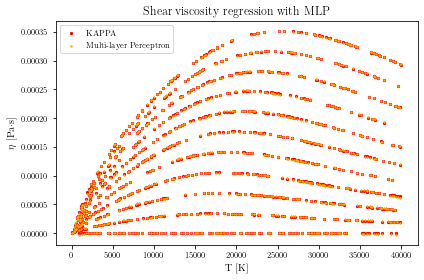

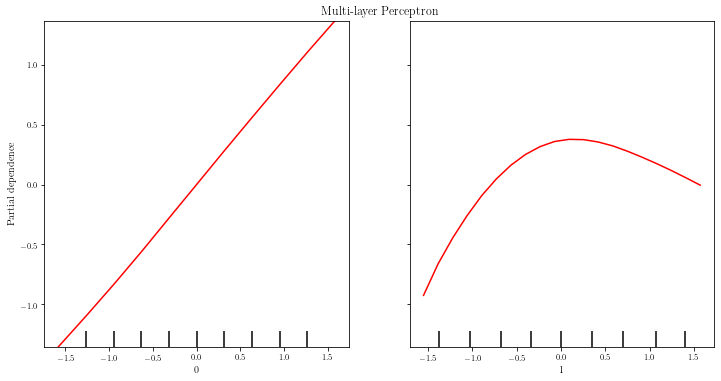

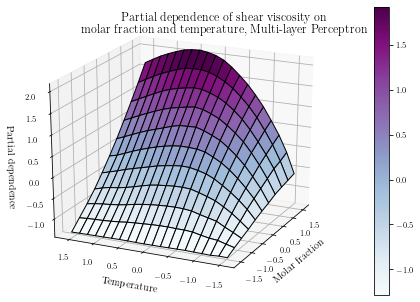

In [28]:
#mlp = MLPRegressor(activation=best_activation, solver=best_solver, learning_rate=best_learning_rate)
mlp = MLPRegressor(activation='relu', solver='lbfgs', learning_rate='adaptive')

t0 = time()
mlp.fit(x_train, y_train.ravel())
mlp_fit = time() - t0
print("MLP complexity and bandwidth selected and model fitted in %.6f s" % mlp_fit)

t0 = time()
y_mlp = mlp.predict(x_test)
mlp_predict = time() - t0
print("MLP prediction for %d inputs in %.6f s" % (x_test.shape[0], mlp_predict))

# open a file to append
outF = open("output.txt", "a")
print("MLP complexity and bandwidth selected and model fitted in %.6f s" % mlp_fit, file=outF)
print("MLP prediction for %d inputs in %.6f s" % (x_test.shape[0], mlp_predict),file=outF)
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_mlp), file=outF)
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_mlp), file=outF)
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_mlp)), file=outF)
outF.close()

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_mlp))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_mlp))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_mlp)))

x_test_dim = sc_x.inverse_transform(x_test)
y_test_dim = sc_y.inverse_transform(y_test)
y_mlp_dim   = sc_y.inverse_transform(y_mlp)

plt.scatter(x_test_dim[:,1], y_test_dim[:], s=5, c='red',     marker='o', label='KAPPA')
#plt.scatter(x_test_dim[:,1], y_svr_dim[:],  s=2, c='blue',    marker='+', label='Support Vector Machine')
#plt.scatter(x_test_dim[:,1], y_kr_dim[:],   s=2, c='green',   marker='p', label='Kernel Ridge')
#plt.scatter(x_test_dim[:,1], y_rf_dim[:],   s=2, c='cyan',    marker='*', label='Random Forest')
#plt.scatter(x_test_dim[:,1], y_kn_dim[:],   s=2, c='magenta', marker='d', label='k-Nearest Neighbour')
#plt.scatter(x_test_dim[:,1], y_gp_dim[:],   s=2, c='orange',  marker='^', label='Gaussian Process')
#plt.scatter(x_test_dim[:,1], y_sgd_dim[:],  s=2, c='yellow',  marker='*', label='Stochastic Gradient Descent')
plt.scatter(x_test_dim[:,1], y_mlp_dim[:],  s=2, c='orange',   marker='*', label='Multi-layer Perceptron')
plt.title('Shear viscosity regression with MLP')
plt.ylabel(r'$\eta$ [Pa·s]')
plt.xlabel('T [K] ')
plt.legend()
plt.tight_layout()
plt.savefig("eta_MLP.pdf", dpi=150, crop='false')
plt.show()

# https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html#sklearn.inspection.plot_partial_dependence

# 2D
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Multi-layer Perceptron")
plot_partial_dependence(mlp, x_train, [0, 1], grid_resolution=20, ax=ax, line_kw={"c": "red"})

# 3D
fig = plt.figure()

pdp, axes = partial_dependence(mlp, x_train, [0,1], grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel("Molar fraction")
ax.set_ylabel("Temperature")
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=-155)
plt.colorbar(surf)
plt.suptitle('Partial dependence of shear viscosity on\n'
             'molar fraction and temperature, Multi-layer Perceptron')
plt.subplots_adjust(top=0.9)
plt.savefig("dependence.pdf", dpi=150, crop='false')
plt.show()